In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [8]:
# shapenet
dataset_type = "shapenet"
class_name = "03211117"
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
input_img_dir = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)

# atlasnet
input_mesh_dir = "/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/{}".format(class_name)
# pix2mesh
#input_mesh_dir = "/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# occnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)


# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

In [9]:
cfg_path = "configs/final_refinement_params.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

#instances = ['2394', '1517', '0191', '1598']
instances = instances[:20]
print(instances)
print(cfg)

['ea4b90cca359e2d38b9be827bf6fc77', 'f800fbcdef1ac9038b5dbcd4be5ceef8', 'd85f501bf76933c609d7d8d27dbba7f', 'f240248beae8d20661049a5d9182333f', 'decec5d8e1f9f54e1a5295d0078b5d60', 'f47044b611046a7bf901627f525bf7a', 'fac8bc5420f9d472b36c473722d8f02c', 'f75d1962eb04669a164790a64bab08f0', 'f5b05e9eedcbaf9cf4d1910799b338b7', 'd7ab9503d7f6dac6b4382097c3e8bcf7', 'dada218e78c9c81e2250bf58700b4d8f', 'dbcd5a88a9d4f1d7579cfe4420588034', 'f5f5e872bf70f59983f551e0fd7d32ac', 'f3bfeab806cc976072052f2ed83934f0', 'df8e098d4dbcb5b2ccc4d915989bc424', 'e1eac12837bcadcf44d2fe7d13c65f0c', 'ffc224f284b63b17b0f6d70666df2668', 'd9bac9c418667d2ba62bc668cb34e698', 'e2787b2f0dd35fccf42a90fe4baf4591', 'df35d335e76abf5618ba239e198ef2ba']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'mode

/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/03211117/ea4b90cca359e2d38b9be827bf6fc77.obj
1.2051281929016113 40.0 125.31018829345703 gt
Input mesh metrics: {'2d_iou_multi': 0.6410589733471473, '2d_iou_input': 0.8438901305198669, '3d_iou': 0.1073202, 'chamfer_L1': 0.00521860783919692, 'chamfer_L1_uniformly': 0.0072774868458509445}



Refined mesh metrics: {'2d_iou_multi': 0.6819192053129276, '2d_iou_input': 0.9533818364143372, '3d_iou': 0.15024859, 'chamfer_L1': 0.0045635211281478405, 'chamfer_L1_uniformly': 0.005787217058241367}


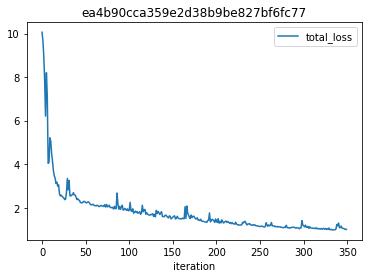

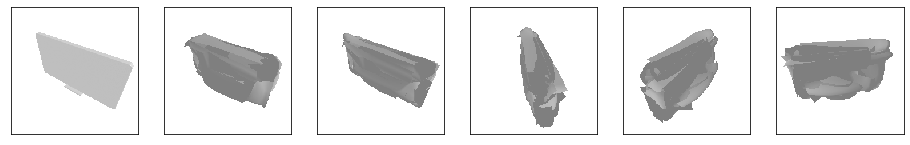

/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/03211117/f800fbcdef1ac9038b5dbcd4be5ceef8.obj
1.2692307233810425 40.0 265.372802734375 gt
Input mesh metrics: {'2d_iou_multi': 0.6067568585276604, '2d_iou_input': 0.8134146928787231, '3d_iou': 0.016023666, 'chamfer_L1': 0.0021661152131855488, 'chamfer_L1_uniformly': 0.00474630668759346}



Refined mesh metrics: {'2d_iou_multi': 0.6462087662269672, '2d_iou_input': 0.9491685628890991, '3d_iou': 0.082027055, 'chamfer_L1': 0.0023020415101200342, 'chamfer_L1_uniformly': 0.003984238486737013}


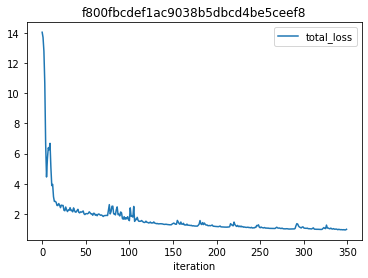

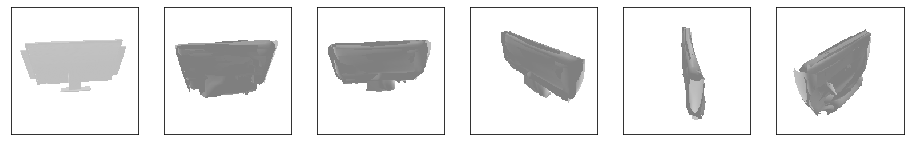

/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/03211117/d85f501bf76933c609d7d8d27dbba7f.obj
1.3333332538604736 40.0 222.77224731445312 gt
Input mesh metrics: {'2d_iou_multi': 0.7033841336766878, '2d_iou_input': 0.756698727607727, '3d_iou': 0.09009554, 'chamfer_L1': 0.003996652085334063, 'chamfer_L1_uniformly': 0.004548274911940098}



Refined mesh metrics: {'2d_iou_multi': 0.7195361852645874, '2d_iou_input': 0.906409740447998, '3d_iou': 0.10422329, 'chamfer_L1': 0.003222433617338538, 'chamfer_L1_uniformly': 0.004496564157307148}


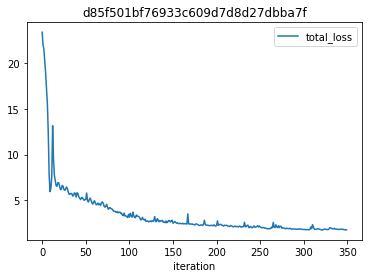

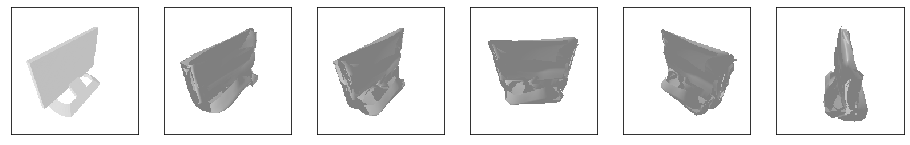

/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/03211117/f240248beae8d20661049a5d9182333f.obj
1.2692307233810425 40.0 322.0618591308594 gt
Input mesh metrics: {'2d_iou_multi': 0.6857021016379198, '2d_iou_input': 0.7517600655555725, '3d_iou': 0.11791075, 'chamfer_L1': 0.004409401677548885, 'chamfer_L1_uniformly': 0.0036039776168763638}


KeyboardInterrupt: 

In [10]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["gt"]
show_metrics = True

results_df = pd.DataFrame()
for instance in instances:
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    print(input_mesh_path)
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        #gt_dist = pose_dict[instance]["dist"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        if show_metrics:
            refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                          metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                          pred_azim=azim, pred_elev=elev, pred_dist=dist)
            print("Refined mesh metrics: {}".format(refined_metrics_dict))
            instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [ ]:
display(results_df)
print(results_df.mean())